In [6]:
# %% TrOCR-SMALL ARCHITECTURE - Full Implementation (OPTIMIZED FOR L4 GPU)
# ====================== Setup / Installs ======================
from google.colab import drive
drive.mount('/content/drive')

# Extract all 3 sets to local storage for faster I/O
import zipfile
import os

DRIVE_BASE = "/content/drive/MyDrive/Full_Dataset/Augmented_Data"
LOCAL_BASE = "/content/dataset"
os.makedirs(LOCAL_BASE, exist_ok=True)

for set_name in ["generated_data"]:
    zip_path = f"{DRIVE_BASE}/{set_name}.zip"
    extract_dir = f"{LOCAL_BASE}/{set_name}"
    if not os.path.exists(extract_dir):
        if os.path.exists(zip_path):
            print(f"Extracting {set_name}...")
            with zipfile.ZipFile(zip_path, 'r') as zf:
                zf.extractall(LOCAL_BASE)
            print(f"  ✓ {set_name} extracted to {extract_dir}")
        else:
            print(f"  ⚠ {zip_path} not found, skipping...")
    else:
        print(f"  ✓ {set_name} already extracted")

!pip -q install albumentations==1.4.7 editdistance==0.8.1 tqdm arabic-reshaper python-bidi transformers timm

# ====================== Imports ======================
import time, random, unicodedata, warnings, math, gc
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, editdistance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import albumentations as A

import arabic_reshaper
from bidi.algorithm import get_display

warnings.filterwarnings("ignore", category=UserWarning)
cv2.setNumThreads(0)

# ====================== Reproducibility & Device ======================
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# =============== CRITICAL GPU OPTIMIZATIONS ===============
torch.backends.cudnn.benchmark = True  # Auto-tune for best convolution algorithms
torch.backends.cudnn.deterministic = False
torch.backends.cuda.matmul.allow_tf32 = True  # Enable TF32 for faster matmul on Ampere+
torch.backends.cudnn.allow_tf32 = True  # Enable TF32 for cuDNN
torch.set_float32_matmul_precision('medium')  # Trade precision for speed

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    total_vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"Total VRAM: {total_vram:.1f} GB")
    # Set memory allocation strategy for better utilization
    torch.cuda.set_per_process_memory_fraction(0.95)  # Use up to 95% of VRAM

def human(n): return f"{n:,}"

def autocast_cuda():
    # Use float16 instead of bfloat16 for better L4 performance
    return torch.amp.autocast("cuda", enabled=(DEVICE=="cuda"), dtype=torch.float16)

def gpu_mem():
    if DEVICE == "cuda":
        a = torch.cuda.memory_allocated()/1e9
        r = torch.cuda.memory_reserved()/1e9
        t = torch.cuda.get_device_properties(0).total_memory/1e9
        return f"GPU: {a:.2f}/{r:.2f}/{t:.1f}GB"
    return "CPU"

# ====================== Data Paths ======================
LOCAL_BASE = Path("/content/dataset")
CSV_PATH = Path("/content/drive/MyDrive/Full_Dataset/Augmented_Data/labels_fixed.csv")
assert CSV_PATH.exists(), f"CSV not found: {CSV_PATH}"
print(f"Labels CSV: {CSV_PATH}")

# ====================== Load & Merge All Sets ======================
df = pd.read_csv(CSV_PATH)
assert {'img_name', 'label', 'class'}.issubset(df.columns)

def normalize_label(s: str) -> str:
    return unicodedata.normalize("NFC", str(s)).strip()

df['label'] = df['label'].astype(str).apply(normalize_label)

def get_img_path(img_name):
  return "/content/dataset/generated_data/" + img_name

df['img_path'] = df['img_name'].apply(get_img_path)
before_filter = len(df)
df = df[df['img_path'].apply(lambda p: p is not None and Path(p).exists())].reset_index(drop=True)
print(f"Images found: {human(len(df))} / {human(before_filter)} ({100*len(df)/before_filter:.1f}%)")

# ====================== Charset (with special tokens for TrOCR) ======================
PAD_TOKEN = '<PAD>'
BOS_TOKEN = '<BOS>'
EOS_TOKEN = '<EOS>'
UNK_TOKEN = '<UNK>'

char_counts = Counter()
for s in df['label']:
    for ch in s:
        char_counts[ch] += 1

charset = [PAD_TOKEN, BOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + sorted(char_counts.keys(), key=lambda c: (-char_counts[c], ord(c)))
char2idx = {c: i for i, c in enumerate(charset)}
idx2char = {i: c for c, i in char2idx.items()}
PAD_IDX = char2idx[PAD_TOKEN]
BOS_IDX = char2idx[BOS_TOKEN]
EOS_IDX = char2idx[EOS_TOKEN]
UNK_IDX = char2idx[UNK_TOKEN]
print(f"Charset size (incl special tokens): {len(charset)}")

# ====================== Style Classes ======================
style_names = sorted(df['class'].fillna("Unknown").unique().tolist())
style2idx = {s: i for i, s in enumerate(style_names)}
idx2style = {i: s for s, i in style2idx.items()}
print(f"Styles ({len(style_names)}): {style_names}")

# ====================== Image Processing ======================
H_TARGET = 64
W_TARGET = 384
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]
MAX_SEQ_LEN = 128

def encode_label_trocr(text):
    """Encode label for TrOCR (with BOS/EOS tokens)."""
    ids = [BOS_IDX]
    for ch in text:
        ids.append(char2idx.get(ch, UNK_IDX))
    ids.append(EOS_IDX)
    return ids

df['enc_len'] = df['label'].apply(lambda s: len(s))
before = len(df)
df = df[df['enc_len'] > 0].reset_index(drop=True)
df = df[df['enc_len'] <= MAX_SEQ_LEN - 2].reset_index(drop=True)
print(f"Filtered by length: {human(before)} -> {human(len(df))}")

def decode_trocr(indices):
    """Decode TrOCR output indices to text."""
    res = []
    for idx in indices:
        if idx == EOS_IDX:
            break
        if idx in [PAD_IDX, BOS_IDX]:
            continue
        res.append(idx2char.get(idx, ''))
    return "".join(res)

def format_arabic_for_display(text):
    try:
        reshaped = arabic_reshaper.reshape(text)
        display_text = get_display(reshaped)
        return display_text
    except:
        return text

# ====================== Train/Val/Test Split ======================
train_df, test_df = train_test_split(df, test_size=0.10, random_state=SEED, stratify=df['class'].fillna("Unknown"))
train_df, val_df = train_test_split(train_df, test_size=0.1111, random_state=SEED, stratify=train_df['class'].fillna("Unknown"))
print(f"\nTrain: {human(len(train_df))} | Val: {human(len(val_df))} | Test: {human(len(test_df))}")

# ====================== Class Balancing ======================
train_class_counts = train_df['class'].value_counts()
median_count = train_class_counts.median()
class_weights = {}
for cls, count in train_class_counts.items():
    weight = np.sqrt(median_count / count)
    weight = np.clip(weight, 1.0, 10.0)
    class_weights[cls] = weight

sample_weights = train_df['class'].map(class_weights).values
sample_weights = torch.DoubleTensor(sample_weights)
effective_per_class = {cls: int(count * class_weights[cls]) for cls, count in train_class_counts.items()}
effective_total = sum(effective_per_class.values())
print(f"Total effective samples/epoch: {effective_total}")

# ====================== Image Processing Functions ======================
def resize_pad_image(img, target_h=H_TARGET, target_w=W_TARGET):
    """Resize image maintaining aspect ratio and pad to target size."""
    h, w = img.shape[:2]
    scale = target_h / h
    new_w = int(w * scale)

    if new_w > target_w:
        scale = target_w / w
        new_h = int(h * scale)
        new_w = target_w
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC)
        pad_top = (target_h - new_h) // 2
        pad_bottom = target_h - new_h - pad_top
        img = cv2.copyMakeBorder(img, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value=255)
    else:
        img = cv2.resize(img, (new_w, target_h), interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC)
        pad_left = 0
        pad_right = target_w - new_w
        img = cv2.copyMakeBorder(img, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=255)

    return img

# ====================== Augmentations ======================
AUG_P = 0.35

train_aug = A.Compose([
    A.ImageCompression(quality_lower=60, quality_upper=95, p=AUG_P),
    A.MotionBlur(blur_limit=3, p=AUG_P * 0.7),
    A.GaussNoise(var_limit=(5.0, 20.0), p=AUG_P * 0.8),
    A.Perspective(scale=(0.02, 0.06), keep_size=True, pad_mode=cv2.BORDER_REPLICATE, p=AUG_P),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.02, rotate_limit=3, border_mode=cv2.BORDER_REPLICATE, p=AUG_P * 0.8),
    A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=AUG_P * 0.8),
])

def apply_train_aug(img):
    return train_aug(image=img)["image"]

# ====================== OPTIMIZED Dataset with Caching ======================
class TrOCRDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, training=True, max_seq_len=MAX_SEQ_LEN):
        self.df = frame.reset_index(drop=True)
        self.training = training
        self.max_seq_len = max_seq_len
        # Pre-compute all labels for faster access
        self.labels = [encode_label_trocr(row['label']) for _, row in self.df.iterrows()]
        self.style_idxs = [style2idx[row['class']] for _, row in self.df.iterrows()]
        self.label_strs = self.df['label'].tolist()
        self.img_paths = self.df['img_path'].tolist()

        # Pre-compute normalization arrays as float32
        self.mean = np.array(MEAN, dtype=np.float32)
        self.std = np.array(STD, dtype=np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        img = cv2.imread(self.img_paths[i], cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.ones((H_TARGET, W_TARGET), dtype=np.uint8) * 255

        label_ids = self.labels[i].copy()
        style_idx = self.style_idxs[i]
        label_str = self.label_strs[i]

        img = resize_pad_image(img, H_TARGET, W_TARGET)

        if self.training:
            img = apply_train_aug(img)

        # Convert to 3-channel
        img = np.stack([img, img, img], axis=-1)

        # Normalize
        img = img.astype(np.float32) / 255.0
        img = (img - self.mean) / self.std
        img_t = torch.from_numpy(img).permute(2, 0, 1)

        # Pad labels
        label_ids = label_ids[:self.max_seq_len]
        label_len = len(label_ids)
        if len(label_ids) < self.max_seq_len:
            label_ids = label_ids + [PAD_IDX] * (self.max_seq_len - len(label_ids))

        return img_t, torch.tensor(label_ids, dtype=torch.long), label_str, torch.tensor(style_idx), label_len

def collate_fn_trocr(batch):
    imgs, labels, label_strs, style_idxs, label_lens = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    labels = torch.stack(labels, dim=0)
    style_idxs = torch.stack(style_idxs, dim=0)
    label_lens = torch.tensor(label_lens, dtype=torch.long)
    return imgs, labels, label_lens, label_strs, style_idxs

# ====================== TrOCR MODEL ARCHITECTURE ======================
print("\n" + "="*60)
print("TrOCR-SMALL MODEL ARCHITECTURE (GPU OPTIMIZED)")
print("="*60)

import timm

class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for decoder."""
    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TrOCRDecoder(nn.Module):
    """Transformer decoder for TrOCR."""
    def __init__(self, vocab_size, d_model=384, nhead=6, num_layers=6,
                 dim_feedforward=1536, dropout=0.1, max_seq_len=128):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.token_embedding = nn.Embedding(vocab_size, d_model, padding_idx=PAD_IDX)
        self.pos_encoding = PositionalEncoding(d_model, max_len=max_seq_len, dropout=dropout)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, vocab_size)
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.zeros_(self.output_proj.bias)

    def generate_square_subsequent_mask(self, sz, device):
        mask = torch.triu(torch.ones(sz, sz, device=device), diagonal=1).bool()
        return mask

    def forward(self, encoder_output, tgt, tgt_key_padding_mask=None):
        tgt_emb = self.token_embedding(tgt)
        tgt_emb = self.pos_encoding(tgt_emb)
        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1), tgt.device)

        output = self.transformer_decoder(
            tgt_emb,
            encoder_output,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        logits = self.output_proj(output)
        return logits

class TrOCRSmall(nn.Module):
    """TrOCR-Small: Vision Transformer encoder + Transformer decoder for OCR."""
    def __init__(self, vocab_size, num_styles, d_model=384, nhead=6,
                 num_decoder_layers=6, dim_feedforward=1536, dropout=0.1,
                 max_seq_len=128, img_size=(64, 384)):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size

        self.encoder = timm.create_model(
            'deit_small_patch16_224',
            pretrained=True,
            img_size=img_size,
            in_chans=3,
            num_classes=0
        )

        encoder_dim = self.encoder.embed_dim

        if encoder_dim != d_model:
            self.encoder_proj = nn.Linear(encoder_dim, d_model)
        else:
            self.encoder_proj = nn.Identity()

        self.decoder = TrOCRDecoder(
            vocab_size=vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            max_seq_len=max_seq_len
        )

        self.style_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(True),
            nn.Dropout(0.25),
            nn.Linear(d_model // 2, num_styles)
        )

    def encode(self, x):
        features = self.encoder.forward_features(x)
        features = self.encoder_proj(features)
        return features

    def forward(self, x, tgt, tgt_key_padding_mask=None):
        encoder_output = self.encode(x)
        logits = self.decoder(encoder_output, tgt, tgt_key_padding_mask)
        cls_token = encoder_output[:, 0]
        style_logits = self.style_head(cls_token)
        return logits, style_logits

    @torch.no_grad()
    def generate(self, x, max_len=None, temperature=1.0):
        if max_len is None:
            max_len = self.max_seq_len

        batch_size = x.size(0)
        device = x.device

        encoder_output = self.encode(x)
        generated = torch.full((batch_size, 1), BOS_IDX, dtype=torch.long, device=device)

        for _ in range(max_len - 1):
            logits = self.decoder(encoder_output, generated)
            next_token_logits = logits[:, -1, :] / temperature
            next_token = next_token_logits.argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)
            if (next_token == EOS_IDX).all():
                break

        return generated

# =============== AGGRESSIVE GPU OPTIMIZATION PARAMETERS ===============
# Calculate optimal batch size based on available VRAM
# L4 has 22.5GB, model is ~22M params, we can fit MUCH larger batches
BATCH_SIZE = 128  # 4x increase from 32 - L4 can handle this easily
GRAD_ACCUM_STEPS = 2  # Effective batch size = 256
EPOCHS = 100
INIT_LR = 5e-4  # Slightly higher LR for larger effective batch
WEIGHT_DECAY = 1e-4
MAX_NORM = 5.0
LAMBDA_CLS = 0.2
LABEL_SMOOTHING = 0.1

# More workers for faster data loading
NUM_WORKERS = 8  # Increased from 4

sampler = WeightedRandomSampler(sample_weights, num_samples=effective_total, replacement=True)

# ====================== Dataloaders with Prefetching ======================
train_ds = TrOCRDataset(train_df, training=True)
val_ds = TrOCRDataset(val_df, training=False)
test_ds = TrOCRDataset(test_df, training=False)

loader_kwargs = dict(
    collate_fn=collate_fn_trocr,
    pin_memory=True,  # Critical for fast CPU->GPU transfer
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    prefetch_factor=4,  # Prefetch more batches
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, **loader_kwargs)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE * 2, shuffle=False, **loader_kwargs)  # Larger val batch (no gradients)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE * 2, shuffle=False, **loader_kwargs)

print(f"Train loader: {len(train_loader)} batches (batch_size={BATCH_SIZE}, effective={BATCH_SIZE*GRAD_ACCUM_STEPS})")
print(f"Val loader: {len(val_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")

# ====================== Model & Optimizer ======================
vocab_size = len(charset)
num_styles = len(style_names)

model = TrOCRSmall(
    vocab_size=vocab_size,
    num_styles=num_styles,
    d_model=384,
    nhead=6,
    num_decoder_layers=6,
    dim_feedforward=1536,
    dropout=0.1,
    max_seq_len=MAX_SEQ_LEN,
    img_size=(H_TARGET, W_TARGET)
).to(DEVICE)

# Convert model to channels_last format for better GPU memory access patterns
model = model.to(memory_format=torch.channels_last)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {human(total_params)}")
print(f"Trainable parameters: {human(trainable_params)}")

# Loss functions
ce_loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=LABEL_SMOOTHING)
cls_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)

# Optimizer with fused AdamW for faster updates
encoder_params = list(model.encoder.parameters())
decoder_params = list(model.decoder.parameters()) + list(model.style_head.parameters())
if hasattr(model, 'encoder_proj') and not isinstance(model.encoder_proj, nn.Identity):
    decoder_params += list(model.encoder_proj.parameters())

# Use fused=True for faster optimizer step on CUDA
optimizer = torch.optim.AdamW([
    {"params": encoder_params, "lr": INIT_LR * 0.1},
    {"params": decoder_params, "lr": INIT_LR}
], weight_decay=WEIGHT_DECAY, fused=True)  # Fused AdamW is faster

# OneCycleLR for faster convergence
steps_per_epoch = len(train_loader) // GRAD_ACCUM_STEPS
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[INIT_LR * 0.1, INIT_LR],
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.1,  # 10% warmup
    anneal_strategy='cos'
)

# Use GradScaler with faster settings
scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE == "cuda"), growth_interval=1000)

# ====================== EMA ======================
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k, v in model.state_dict().items()}

    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            if v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v, alpha=1.0 - self.decay)
            else:
                self.shadow[k] = v.clone()

    def apply_to(self, model):
        self._backup = {k: v.clone() for k, v in model.state_dict().items()}
        model.load_state_dict(self.shadow, strict=False)

    def restore(self, model):
        model.load_state_dict(self._backup, strict=False)
        del self._backup

ema = EMA(model, decay=0.999)

# ====================== Metrics ======================
def cer(ref, hyp):
    return 0.0 if (len(ref) == 0 and len(hyp) == 0) else editdistance.eval(ref, hyp) / max(1, len(ref))

def wer(ref, hyp):
    r, h = ref.split(), hyp.split()
    return 0.0 if (len(r) == 0 and len(h) == 0) else editdistance.eval(r, h) / max(1, len(r))

# ====================== Optimized Evaluation ======================
@torch.no_grad()
def evaluate_trocr(model, loader, use_ema=False):
    if use_ema:
        ema.apply_to(model)
    model.eval()

    tot_loss = tot_cer = tot_wer = 0.0
    cnt = 0
    cls_correct = cls_total = 0

    for imgs, labels, label_lens, label_strs, style_idxs in loader:
        # Use channels_last for faster GPU processing
        imgs = imgs.to(DEVICE, memory_format=torch.channels_last, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        style_idxs = style_idxs.to(DEVICE, non_blocking=True)

        tgt_key_padding_mask = (labels == PAD_IDX)

        with autocast_cuda():
            tgt_input = labels[:, :-1]
            tgt_output = labels[:, 1:]
            tgt_mask = tgt_key_padding_mask[:, :-1]

            logits, style_logits = model(imgs, tgt_input, tgt_mask)

            logits_flat = logits.reshape(-1, vocab_size)
            tgt_flat = tgt_output.reshape(-1)

            loss_ce = ce_loss_fn(logits_flat, tgt_flat)
            loss_cls = cls_loss_fn(style_logits, style_idxs)
            loss = loss_ce + LAMBDA_CLS * loss_cls

        B = imgs.size(0)
        tot_loss += loss.item() * B
        cnt += B

        generated = model.generate(imgs, max_len=MAX_SEQ_LEN)
        preds = [decode_trocr(gen.tolist()) for gen in generated]

        for gt, pr in zip(label_strs, preds):
            tot_cer += cer(gt, pr)
            tot_wer += wer(gt, pr)

        pred_style = style_logits.argmax(dim=1)
        cls_correct += (pred_style == style_idxs).sum().item()
        cls_total += B

    if use_ema:
        ema.restore(model)

    return {
        "loss": tot_loss / cnt if cnt else None,
        "cer": tot_cer / cnt if cnt else None,
        "wer": tot_wer / cnt if cnt else None,
        "style_acc": cls_correct / cls_total if cls_total > 0 else None
    }

# ====================== Optimized Training Loop ======================
print("\n" + "="*60)
print("TRAINING TrOCR-SMALL (GPU OPTIMIZED)")
print("="*60)

SAVE_DIR = Path("./checkpoints_trocr")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH = SAVE_DIR / "trocr_best.pt"
BEST_EMA_PATH = SAVE_DIR / "trocr_best_ema.pt"

history = {
    "train_loss": [], "val_loss": [],
    "val_cer_raw": [], "val_cer_ema": [],
    "val_wer_raw": [], "val_wer_ema": [],
    "val_style_acc_raw": [], "val_style_acc_ema": []
}

best_cer_raw = float('inf')
best_cer_ema = float('inf')

# Freeze encoder for first few epochs (warmup)
WARMUP_EPOCHS = 2  # Reduced warmup for faster training
for p in model.encoder.parameters():
    p.requires_grad = False
print(f"Encoder frozen for {WARMUP_EPOCHS} warmup epochs.")

print(f"\n[Training] Epochs={EPOCHS}, Batch={BATCH_SIZE}x{GRAD_ACCUM_STEPS}={BATCH_SIZE*GRAD_ACCUM_STEPS} effective")
print(f"Device: {DEVICE} | {gpu_mem()}\n")

# CUDA warmup
print("Warming up CUDA...")
dummy = torch.randn(BATCH_SIZE, 3, H_TARGET, W_TARGET, device=DEVICE).to(memory_format=torch.channels_last)
dummy_tgt = torch.randint(0, vocab_size, (BATCH_SIZE, MAX_SEQ_LEN-1), device=DEVICE)
with autocast_cuda():
    _ = model(dummy, dummy_tgt)
del dummy, dummy_tgt
torch.cuda.synchronize()
torch.cuda.empty_cache()
print("CUDA warmed up!\n")

for epoch in range(1, EPOCHS + 1):
    # Unfreeze encoder after warmup
    if epoch == WARMUP_EPOCHS + 1:
        for p in model.encoder.parameters():
            p.requires_grad = True
        print("Encoder unfrozen.")

    model.train()
    running = 0.0
    seen = 0
    nan_batches = 0
    t0 = time.time()

    optimizer.zero_grad(set_to_none=True)

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch:03d}", leave=False)
    for bidx, (imgs, labels, label_lens, label_strs, style_idxs) in pbar:
        # Use channels_last and non_blocking for faster transfer
        imgs = imgs.to(DEVICE, memory_format=torch.channels_last, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        style_idxs = style_idxs.to(DEVICE, non_blocking=True)

        tgt_key_padding_mask = (labels == PAD_IDX)

        with autocast_cuda():
            tgt_input = labels[:, :-1]
            tgt_output = labels[:, 1:]
            tgt_mask = tgt_key_padding_mask[:, :-1]

            logits, style_logits = model(imgs, tgt_input, tgt_mask)

            logits_flat = logits.reshape(-1, vocab_size)
            tgt_flat = tgt_output.reshape(-1)

            loss_ce = ce_loss_fn(logits_flat, tgt_flat)
            loss_cls = cls_loss_fn(style_logits, style_idxs)
            loss = (loss_ce + LAMBDA_CLS * loss_cls) / GRAD_ACCUM_STEPS  # Scale for accumulation

        if torch.isnan(loss) or torch.isinf(loss):
            nan_batches += 1
            continue

        scaler.scale(loss).backward()

        # Gradient accumulation step
        if (bidx + 1) % GRAD_ACCUM_STEPS == 0 or (bidx + 1) == len(train_loader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            ema.update(model)

        running += loss.item() * GRAD_ACCUM_STEPS * imgs.size(0)
        seen += imgs.size(0)
        pbar.set_postfix(loss=f"{loss.item()*GRAD_ACCUM_STEPS:.3f}", avg=f"{running/max(1,seen):.3f}", mem=gpu_mem())

    train_loss = running / max(1, seen) if seen > 0 else float('nan')
    history["train_loss"].append(train_loss)

    if nan_batches > 0:
        print(f"  Warning: {nan_batches} batches skipped due to NaN loss")

    # Validation (every epoch)
    # val_raw = evaluate_trocr(model, val_loader, use_ema=False)

    # val_ema = evaluate_trocr(model, val_loader, use_ema=True)

    DO_VAL_EVERY = 5

    if epoch % DO_VAL_EVERY == 0 or epoch == 1:
        val_raw = evaluate_trocr(model, val_loader, use_ema=False)
        val_ema = evaluate_trocr(model, val_loader, use_ema=True)
        # log/save best, etc.
    else:
        # Cheap placeholder so code doesn’t break
        val_raw = {"loss": float('nan'), "cer": float('nan'),
                  "wer": float('nan'), "style_acc": float('nan')}
        val_ema = {"loss": float('nan'), "cer": float('nan'),
                  "wer": float('nan'), "style_acc": float('nan')}

    history["val_loss"].append(val_raw["loss"])
    history["val_cer_raw"].append(val_raw["cer"])
    history["val_cer_ema"].append(val_ema["cer"])
    history["val_wer_raw"].append(val_raw["wer"])
    history["val_wer_ema"].append(val_ema["wer"])
    history["val_style_acc_raw"].append(val_raw["style_acc"])
    history["val_style_acc_ema"].append(val_ema["style_acc"])

    dt = time.time() - t0
    print(f"Epoch {epoch:03d}/{EPOCHS} | train={train_loss:.3f} | "
          f"val_raw: CER={val_raw['cer']:.4f} WER={val_raw['wer']:.4f} style={val_raw['style_acc']:.3f} | "
          f"val_EMA: CER={val_ema['cer']:.4f} WER={val_ema['wer']:.4f} style={val_ema['style_acc']:.3f} | "
          f"{dt:.1f}s | {gpu_mem()}")

    # Save best RAW model
    if val_raw["cer"] is not None and val_raw["cer"] < best_cer_raw:
        best_cer_raw = val_raw["cer"]
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "charset": charset,
            "style_names": style_names,
            "config": {"H_TARGET": H_TARGET, "W_TARGET": W_TARGET, "MAX_SEQ_LEN": MAX_SEQ_LEN},
            "metrics": val_raw
        }, BEST_PATH)
        print(f"  ✓ New best RAW CER={best_cer_raw:.4f}")

    # Save best EMA model
    if val_ema["cer"] is not None and val_ema["cer"] < best_cer_ema:
        best_cer_ema = val_ema["cer"]
        ema.apply_to(model)
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "charset": charset,
            "style_names": style_names,
            "config": {"H_TARGET": H_TARGET, "W_TARGET": W_TARGET, "MAX_SEQ_LEN": MAX_SEQ_LEN},
            "metrics": val_ema
        }, BEST_EMA_PATH)
        ema.restore(model)
        print(f"  ✓ New best EMA CER={best_cer_ema:.4f}")

    if epoch % 10 == 0:
        gc.collect()
        torch.cuda.empty_cache()

print("\n[Training] Complete!")
print(f"Best RAW CER: {best_cer_raw:.4f}")
print(f"Best EMA CER: {best_cer_ema:.4f}")

# ====================== Training Curves ======================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history["train_loss"], label="Train")
axes[0, 0].plot(history["val_loss"], label="Val")
axes[0, 0].set_title("Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history["val_cer_raw"], label="Val CER (raw)")
axes[0, 1].plot(history["val_cer_ema"], label="Val CER (EMA)")
axes[0, 1].set_title("Character Error Rate")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history["val_wer_raw"], label="Val WER (raw)")
axes[1, 0].plot(history["val_wer_ema"], label="Val WER (EMA)")
axes[1, 0].set_title("Word Error Rate")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history["val_style_acc_raw"], label="Style Acc (raw)")
axes[1, 1].plot(history["val_style_acc_ema"], label="Style Acc (EMA)")
axes[1, 1].set_title("Style Classification Accuracy")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.suptitle("TrOCR-Small Training Curves", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(SAVE_DIR / "trocr_training_curves.png", dpi=150)
plt.show()

# ====================== Test Evaluation ======================
print("\n" + "="*60)
print("TEST EVALUATION (TrOCR-SMALL)")
print("="*60)

ckpt = torch.load(BEST_EMA_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"], strict=False)
model.eval()

test_metrics = evaluate_trocr(model, test_loader, use_ema=False)
print(f"\nTEST (Best EMA) — CER={test_metrics['cer']:.4f} | WER={test_metrics['wer']:.4f} | "
      f"Style Acc={test_metrics['style_acc']:.4f}")

# ====================== Sample Visualization ======================
print("\n" + "="*60)
print("SAMPLE PREDICTIONS (TrOCR-Small)")
print("="*60)

plt.rcParams['font.family'] = 'DejaVu Sans'

@torch.no_grad()
def show_samples_trocr(model, loader, k=12):
    model.eval()
    imgs, labels, label_lens, label_strs, style_idxs = next(iter(loader))
    imgs = imgs.to(DEVICE, memory_format=torch.channels_last)
    style_idxs = style_idxs.to(DEVICE)

    generated = model.generate(imgs, max_len=MAX_SEQ_LEN)
    preds = [decode_trocr(gen.tolist()) for gen in generated]

    encoder_output = model.encode(imgs)
    cls_token = encoder_output[:, 0]
    style_logits = model.style_head(cls_token)
    style_pred = style_logits.softmax(1).argmax(1).cpu().tolist()

    n_samples = min(k, imgs.size(0))
    n_cols = 2
    n_rows = (n_samples + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
    axes = axes.flatten() if n_samples > 1 else [axes]

    correct = 0
    total = 0

    for i in range(n_samples):
        im = imgs[i].cpu().numpy().transpose(1, 2, 0)
        im = im * np.array(STD) + np.array(MEAN)
        im = np.clip(im, 0, 1)
        im = im[:, :, 0]

        gt_style = idx2style[style_idxs[i].item()]
        pr_style = idx2style[style_pred[i]]
        gt_text = label_strs[i]
        pr_text = preds[i]

        gt_display = format_arabic_for_display(gt_text)
        pr_display = format_arabic_for_display(pr_text)

        match = gt_text == pr_text
        if match:
            correct += 1
        total += 1

        match_symbol = "✓" if match else "✗"
        match_color = "green" if match else "red"
        style_match = "✓" if gt_style == pr_style else "✗"

        axes[i].imshow(im, cmap='gray')
        axes[i].axis('off')

        title = f"Style: {gt_style} → {pr_style} {style_match}\n"
        title += f"GT:   {gt_display}\n"
        title += f"Pred: {pr_display}  {match_symbol}"

        axes[i].set_title(title, fontsize=11, color=match_color if not match else 'black',
                         fontfamily='DejaVu Sans', ha='center')

    for i in range(n_samples, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f"TrOCR-Small Predictions - Accuracy: {correct}/{total} ({100*correct/total:.1f}%)",
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(SAVE_DIR / "trocr_sample_predictions.png", dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Saved to {SAVE_DIR / 'trocr_sample_predictions.png'}")
    print(f"  Sample accuracy: {correct}/{total} ({100*correct/total:.1f}%)")

show_samples_trocr(model, test_loader, k=12)

# ====================== Final Summary ======================
print("\n" + "="*60)
print("TrOCR-SMALL FINAL SUMMARY (GPU OPTIMIZED)")
print("="*60)
print(f"Dataset = {human(len(df))} images")
print(f"Classes: {len(style_names)} styles")
print(f"Vocab size: {vocab_size} tokens")
print(f"Model parameters: {human(total_params)}")
print(f"Batch size: {BATCH_SIZE} x {GRAD_ACCUM_STEPS} = {BATCH_SIZE*GRAD_ACCUM_STEPS} effective")
print(f"\nBest Validation CER (RAW): {best_cer_raw:.4f}")
print(f"Best Validation CER (EMA): {best_cer_ema:.4f}")
print(f"\nTest Metrics:")
print(f"  - CER: {test_metrics['cer']:.4f}")
print(f"  - WER: {test_metrics['wer']:.4f}")
print(f"  - Style Accuracy: {test_metrics['style_acc']:.4f}")
print(f"\nCheckpoints saved to: {SAVE_DIR}")
print("✅ TrOCR-Small Run Complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  ✓ generated_data already extracted
Device: cuda
GPU: NVIDIA L4
Total VRAM: 23.8 GB
Labels CSV: /content/drive/MyDrive/Full_Dataset/Augmented_Data/labels_fixed.csv
Images found: 9,913 / 9,914 (100.0%)
Charset size (incl special tokens): 65
Styles (3): ['Diwani', 'Kufic', 'Thuluth']
Filtered by length: 9,913 -> 9,913

Train: 7,929 | Val: 992 | Test: 992
Total effective samples/epoch: 8219

TrOCR-SMALL MODEL ARCHITECTURE (GPU OPTIMIZED)
Train loader: 65 batches (batch_size=128, effective=256)
Val loader: 4 batches
Test loader: 4 batches
Total parameters: 35,951,300
Trainable parameters: 35,951,300

TRAINING TrOCR-SMALL (GPU OPTIMIZED)
Encoder frozen for 2 warmup epochs.

[Training] Epochs=100, Batch=128x2=256 effective
Device: cuda | GPU: 2.89/14.75/23.8GB

Warming up CUDA...
CUDA warmed up!



Epoch 001:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 001/100 | train=3.830 | val_raw: CER=2.8554 WER=1.0000 style=0.591 | val_EMA: CER=2.9318 WER=1.0000 style=0.374 | 140.9s | GPU: 2.83/14.29/23.8GB
  ✓ New best RAW CER=2.8554
  ✓ New best EMA CER=2.9318


Epoch 002:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 002/100 | train=3.582 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 55.0s | GPU: 2.83/14.29/23.8GB
Encoder unfrozen.


Epoch 003:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 003/100 | train=3.463 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.6s | GPU: 3.01/14.33/23.8GB


Epoch 004:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 004/100 | train=3.367 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.4s | GPU: 3.01/14.33/23.8GB


Epoch 005:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 005/100 | train=3.325 | val_raw: CER=0.8837 WER=1.0532 style=0.991 | val_EMA: CER=2.4466 WER=1.0000 style=0.504 | 140.7s | GPU: 3.01/14.33/23.8GB
  ✓ New best RAW CER=0.8837
  ✓ New best EMA CER=2.4466


Epoch 006:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 006/100 | train=3.291 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 52.2s | GPU: 3.01/14.33/23.8GB


Epoch 007:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 007/100 | train=3.064 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.4s | GPU: 3.01/14.33/23.8GB


Epoch 008:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 008/100 | train=2.895 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.2s | GPU: 3.01/14.33/23.8GB


Epoch 009:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 009/100 | train=2.652 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.8s | GPU: 3.01/14.33/23.8GB


Epoch 010:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 010/100 | train=2.491 | val_raw: CER=0.7264 WER=1.0014 style=0.999 | val_EMA: CER=2.0115 WER=1.0098 style=0.823 | 140.4s | GPU: 3.01/14.33/23.8GB
  ✓ New best RAW CER=0.7264
  ✓ New best EMA CER=2.0115


Epoch 011:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 011/100 | train=2.345 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.3s | GPU: 2.86/8.26/23.8GB


Epoch 012:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 012/100 | train=2.212 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.5s | GPU: 2.86/8.26/23.8GB


Epoch 013:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 013/100 | train=2.105 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.4s | GPU: 2.86/8.26/23.8GB


Epoch 014:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 014/100 | train=2.006 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.2s | GPU: 2.86/8.26/23.8GB


Epoch 015:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 015/100 | train=1.927 | val_raw: CER=0.7018 WER=0.9083 style=1.000 | val_EMA: CER=1.4871 WER=1.2859 style=0.935 | 140.9s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.7018
  ✓ New best EMA CER=1.4871


Epoch 016:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 016/100 | train=1.869 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.9s | GPU: 2.86/16.76/23.8GB


Epoch 017:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 017/100 | train=1.800 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.4s | GPU: 2.86/16.76/23.8GB


Epoch 018:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 018/100 | train=1.742 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.8s | GPU: 2.86/16.76/23.8GB


Epoch 019:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 019/100 | train=1.696 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.4s | GPU: 2.86/16.76/23.8GB


Epoch 020:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 020/100 | train=1.644 | val_raw: CER=0.6303 WER=0.8365 style=0.999 | val_EMA: CER=1.1606 WER=1.3800 style=0.981 | 140.5s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.6303
  ✓ New best EMA CER=1.1606


Epoch 021:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 021/100 | train=1.608 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.4s | GPU: 2.86/8.26/23.8GB


Epoch 022:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 022/100 | train=1.576 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.0s | GPU: 2.86/8.26/23.8GB


Epoch 023:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 023/100 | train=1.540 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 55.0s | GPU: 2.86/8.26/23.8GB


Epoch 024:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 024/100 | train=1.508 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.4s | GPU: 2.86/8.26/23.8GB


Epoch 025:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 025/100 | train=1.486 | val_raw: CER=0.6236 WER=0.8202 style=0.999 | val_EMA: CER=1.2180 WER=1.2897 style=0.988 | 140.1s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.6236


Epoch 026:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 026/100 | train=1.456 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 52.5s | GPU: 2.86/16.76/23.8GB


Epoch 027:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 027/100 | train=1.431 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.6s | GPU: 2.86/16.76/23.8GB


Epoch 028:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 028/100 | train=1.409 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.6s | GPU: 2.86/16.76/23.8GB


Epoch 029:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 029/100 | train=1.390 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.3s | GPU: 2.86/16.76/23.8GB


Epoch 030:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 030/100 | train=1.368 | val_raw: CER=0.5962 WER=0.7874 style=1.000 | val_EMA: CER=1.6127 WER=1.3262 style=0.996 | 140.3s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.5962


Epoch 031:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 031/100 | train=1.348 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.4s | GPU: 2.86/8.26/23.8GB


Epoch 032:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 032/100 | train=1.329 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.5s | GPU: 2.86/8.26/23.8GB


Epoch 033:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 033/100 | train=1.309 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.3s | GPU: 2.86/8.26/23.8GB


Epoch 034:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 034/100 | train=1.292 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.3s | GPU: 2.86/8.26/23.8GB


Epoch 035:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 035/100 | train=1.276 | val_raw: CER=0.5587 WER=0.7510 style=1.000 | val_EMA: CER=1.7079 WER=1.3839 style=0.998 | 140.1s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.5587


Epoch 036:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 036/100 | train=1.258 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.6s | GPU: 2.86/16.76/23.8GB


Epoch 037:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 037/100 | train=1.242 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 55.1s | GPU: 2.86/16.76/23.8GB


Epoch 038:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 038/100 | train=1.230 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.6s | GPU: 2.86/16.76/23.8GB


Epoch 039:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 039/100 | train=1.210 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.6s | GPU: 2.86/16.76/23.8GB


Epoch 040:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 040/100 | train=1.198 | val_raw: CER=0.5319 WER=0.7234 style=1.000 | val_EMA: CER=1.4334 WER=1.2975 style=1.000 | 139.6s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.5319


Epoch 041:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 041/100 | train=1.185 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 55.0s | GPU: 2.86/8.26/23.8GB


Epoch 042:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 042/100 | train=1.172 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.8s | GPU: 2.86/8.26/23.8GB


Epoch 043:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 043/100 | train=1.160 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 52.5s | GPU: 2.86/8.26/23.8GB


Epoch 044:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 044/100 | train=1.142 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.6s | GPU: 2.86/8.26/23.8GB


Epoch 045:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 045/100 | train=1.129 | val_raw: CER=0.5278 WER=0.7140 style=1.000 | val_EMA: CER=0.9469 WER=1.1301 style=1.000 | 138.3s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.5278
  ✓ New best EMA CER=0.9469


Epoch 046:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 046/100 | train=1.119 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.6s | GPU: 2.86/16.76/23.8GB


Epoch 047:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 047/100 | train=1.108 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.0s | GPU: 2.86/16.76/23.8GB


Epoch 048:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 048/100 | train=1.098 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.2s | GPU: 2.86/16.76/23.8GB


Epoch 049:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 049/100 | train=1.087 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.2s | GPU: 2.86/16.76/23.8GB


Epoch 050:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 050/100 | train=1.077 | val_raw: CER=0.5063 WER=0.6898 style=0.999 | val_EMA: CER=0.6632 WER=0.9430 style=1.000 | 137.3s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.5063
  ✓ New best EMA CER=0.6632


Epoch 051:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 051/100 | train=1.068 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.3s | GPU: 2.86/8.26/23.8GB


Epoch 052:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 052/100 | train=1.064 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.4s | GPU: 2.86/8.26/23.8GB


Epoch 053:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 053/100 | train=1.056 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.5s | GPU: 2.86/8.26/23.8GB


Epoch 054:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 054/100 | train=1.044 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.7s | GPU: 2.86/8.26/23.8GB


Epoch 055:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 055/100 | train=1.036 | val_raw: CER=0.4960 WER=0.6777 style=0.999 | val_EMA: CER=0.6277 WER=0.8710 style=1.000 | 138.5s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.4960
  ✓ New best EMA CER=0.6277


Epoch 056:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 056/100 | train=1.029 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 52.6s | GPU: 2.86/16.76/23.8GB


Epoch 057:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 057/100 | train=1.022 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 52.2s | GPU: 2.86/16.76/23.8GB


Epoch 058:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 058/100 | train=1.012 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.9s | GPU: 2.86/16.76/23.8GB


Epoch 059:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 059/100 | train=1.008 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.9s | GPU: 2.86/16.76/23.8GB


Epoch 060:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 060/100 | train=1.001 | val_raw: CER=0.4889 WER=0.6714 style=0.999 | val_EMA: CER=0.5914 WER=0.8077 style=1.000 | 138.3s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.4889
  ✓ New best EMA CER=0.5914


Epoch 061:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 061/100 | train=0.998 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.8s | GPU: 2.86/8.26/23.8GB


Epoch 062:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 062/100 | train=0.990 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.8s | GPU: 2.86/8.26/23.8GB


Epoch 063:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 063/100 | train=0.983 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.7s | GPU: 2.86/8.26/23.8GB


Epoch 064:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 064/100 | train=0.980 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.8s | GPU: 2.86/8.26/23.8GB


Epoch 065:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 065/100 | train=0.976 | val_raw: CER=0.4902 WER=0.6697 style=0.999 | val_EMA: CER=0.5664 WER=0.7669 style=1.000 | 138.0s | GPU: 2.86/16.76/23.8GB
  ✓ New best EMA CER=0.5664


Epoch 066:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 066/100 | train=0.971 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.4s | GPU: 2.86/16.76/23.8GB


Epoch 067:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 067/100 | train=0.966 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 52.7s | GPU: 2.86/16.76/23.8GB


Epoch 068:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 068/100 | train=0.963 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 55.4s | GPU: 2.86/16.76/23.8GB


Epoch 069:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 069/100 | train=0.959 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.5s | GPU: 2.86/16.76/23.8GB


Epoch 070:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 070/100 | train=0.955 | val_raw: CER=0.4743 WER=0.6485 style=1.000 | val_EMA: CER=0.5479 WER=0.7438 style=1.000 | 139.0s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.4743
  ✓ New best EMA CER=0.5479


Epoch 071:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 071/100 | train=0.952 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.3s | GPU: 2.86/8.26/23.8GB


Epoch 072:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 072/100 | train=0.949 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.1s | GPU: 2.86/8.26/23.8GB


Epoch 073:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 073/100 | train=0.945 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.2s | GPU: 2.86/8.26/23.8GB


Epoch 074:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 074/100 | train=0.943 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.4s | GPU: 2.86/8.26/23.8GB


Epoch 075:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 075/100 | train=0.941 | val_raw: CER=0.4727 WER=0.6499 style=0.999 | val_EMA: CER=0.5345 WER=0.7260 style=1.000 | 137.0s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.4727
  ✓ New best EMA CER=0.5345


Epoch 076:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 076/100 | train=0.938 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.1s | GPU: 2.86/16.76/23.8GB


Epoch 077:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 077/100 | train=0.938 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.8s | GPU: 2.86/16.76/23.8GB


Epoch 078:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 078/100 | train=0.934 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.7s | GPU: 2.86/16.76/23.8GB


Epoch 079:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 079/100 | train=0.932 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 55.2s | GPU: 2.86/16.76/23.8GB


Epoch 080:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 080/100 | train=0.931 | val_raw: CER=0.4706 WER=0.6448 style=1.000 | val_EMA: CER=0.5209 WER=0.7068 style=1.000 | 138.1s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.4706
  ✓ New best EMA CER=0.5209


Epoch 081:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 081/100 | train=0.928 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.2s | GPU: 2.86/8.26/23.8GB


Epoch 082:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 082/100 | train=0.928 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.4s | GPU: 2.86/8.26/23.8GB


Epoch 083:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 083/100 | train=0.926 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.9s | GPU: 2.86/8.26/23.8GB


Epoch 084:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 084/100 | train=0.924 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.2s | GPU: 2.86/8.26/23.8GB


Epoch 085:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 085/100 | train=0.925 | val_raw: CER=0.4683 WER=0.6456 style=1.000 | val_EMA: CER=0.5101 WER=0.6927 style=1.000 | 139.1s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.4683
  ✓ New best EMA CER=0.5101


Epoch 086:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 086/100 | train=0.923 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 53.9s | GPU: 2.86/16.76/23.8GB


Epoch 087:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 087/100 | train=0.922 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.0s | GPU: 2.86/16.76/23.8GB


Epoch 088:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 088/100 | train=0.922 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.6s | GPU: 2.86/16.76/23.8GB


Epoch 089:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 089/100 | train=0.922 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.5s | GPU: 2.86/16.76/23.8GB


Epoch 090:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 090/100 | train=0.922 | val_raw: CER=0.4693 WER=0.6429 style=1.000 | val_EMA: CER=0.5018 WER=0.6838 style=1.000 | 139.0s | GPU: 2.86/16.76/23.8GB
  ✓ New best EMA CER=0.5018


Epoch 091:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 091/100 | train=0.919 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.5s | GPU: 2.86/8.26/23.8GB


Epoch 092:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 092/100 | train=0.919 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.7s | GPU: 2.86/8.26/23.8GB


Epoch 093:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 093/100 | train=0.920 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.1s | GPU: 2.86/8.26/23.8GB


Epoch 094:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 094/100 | train=0.920 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.9s | GPU: 2.86/8.26/23.8GB


Epoch 095:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 095/100 | train=0.919 | val_raw: CER=0.4671 WER=0.6422 style=1.000 | val_EMA: CER=0.4957 WER=0.6763 style=1.000 | 136.5s | GPU: 2.86/16.76/23.8GB
  ✓ New best RAW CER=0.4671
  ✓ New best EMA CER=0.4957


Epoch 096:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 096/100 | train=0.919 | val_raw: CER=nan WER=nan style=nan | val_EMA: CER=nan WER=nan style=nan | 54.4s | GPU: 2.86/16.76/23.8GB


Epoch 097:   0%|          | 0/65 [00:00<?, ?it/s]

ValueError: Tried to step 3201 times. The specified number of total steps is 3200

## GET PLOTS (97 epochs only)

Total epochs: 96
Epochs with validation: [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


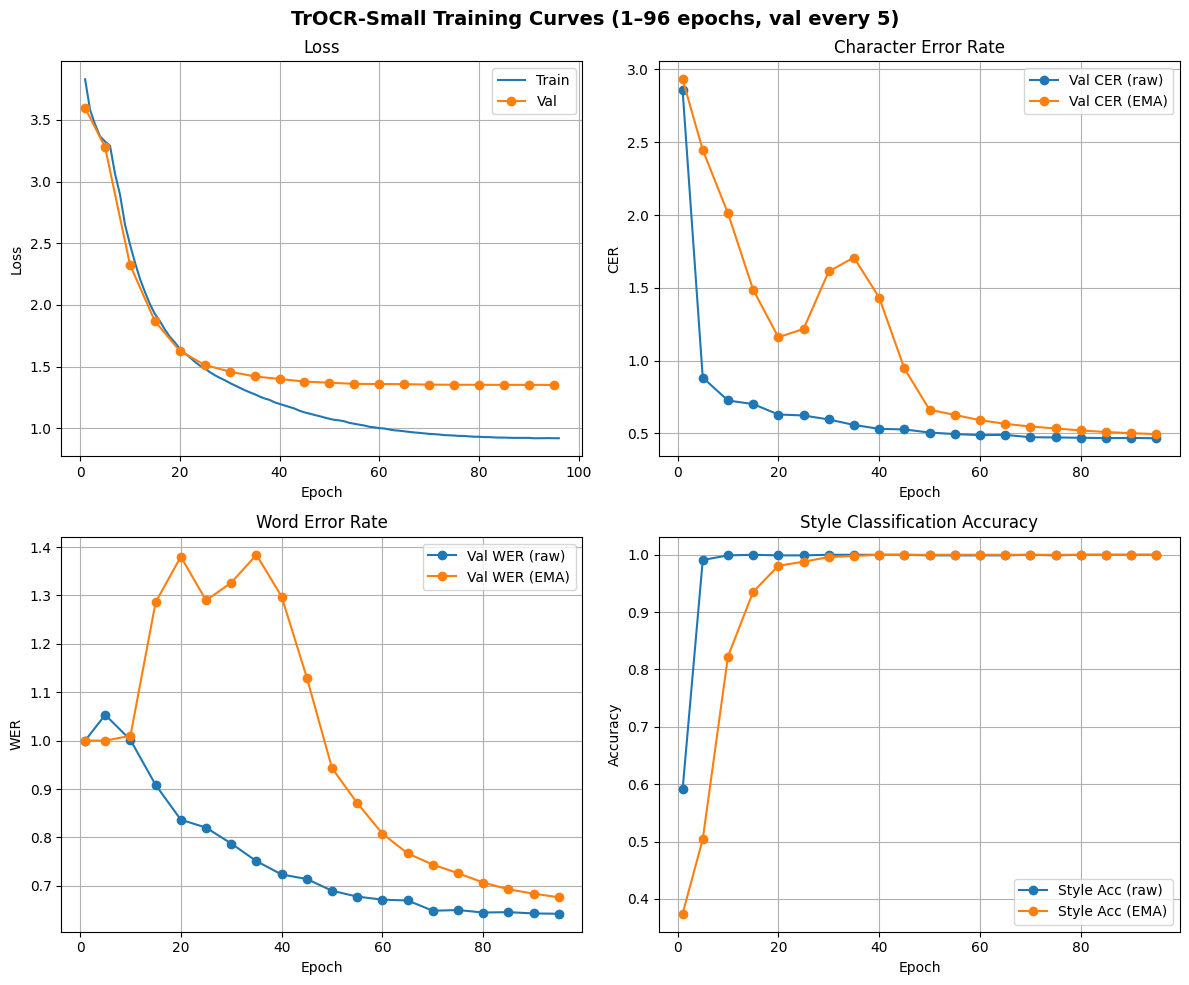

✓ Saved training curves to: checkpoints_trocr/trocr_training_curves_valid_only_until_epoch_096.png


In [8]:
# %% RE-PLOT TRAINING CURVES USING ONLY EPOCHS WITH VALIDATION

import numpy as np
import matplotlib.pyplot as plt

assert isinstance(history, dict), "history dict not found."

num_epochs = len(history["train_loss"])
epochs_full = np.arange(1, num_epochs + 1)

def arr(key):
    vals = history.get(key, [])
    vals = vals[:num_epochs]
    return np.array(vals, dtype=float)

train_loss      = arr("train_loss")
val_loss        = arr("val_loss")
val_cer_raw     = arr("val_cer_raw")
val_cer_ema     = arr("val_cer_ema")
val_wer_raw     = arr("val_wer_raw")
val_wer_ema     = arr("val_wer_ema")
val_style_raw   = arr("val_style_acc_raw")
val_style_ema   = arr("val_style_acc_ema")

# Mask: epochs where we actually did validation (non-NaN CER)
val_mask = ~np.isnan(val_cer_raw)
epochs_val = epochs_full[val_mask]

val_loss_v      = val_loss[val_mask]
val_cer_raw_v   = val_cer_raw[val_mask]
val_cer_ema_v   = val_cer_ema[val_mask]
val_wer_raw_v   = val_wer_raw[val_mask]
val_wer_ema_v   = val_wer_ema[val_mask]
val_style_raw_v = val_style_raw[val_mask]
val_style_ema_v = val_style_ema[val_mask]

print(f"Total epochs: {num_epochs}")
print(f"Epochs with validation: {epochs_val.tolist()}")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ---------- Loss ----------
axes[0, 0].plot(epochs_full, train_loss, label="Train")
if len(epochs_val) > 0:
    axes[0, 0].plot(epochs_val, val_loss_v, "o-", label="Val")
axes[0, 0].set_title("Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)

# ---------- CER ----------
if len(epochs_val) > 0:
    axes[0, 1].plot(epochs_val, val_cer_raw_v, "o-", label="Val CER (raw)")
    axes[0, 1].plot(epochs_val, val_cer_ema_v, "o-", label="Val CER (EMA)")
axes[0, 1].set_title("Character Error Rate")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("CER")
axes[0, 1].legend()
axes[0, 1].grid(True)

# ---------- WER ----------
if len(epochs_val) > 0:
    axes[1, 0].plot(epochs_val, val_wer_raw_v, "o-", label="Val WER (raw)")
    axes[1, 0].plot(epochs_val, val_wer_ema_v, "o-", label="Val WER (EMA)")
axes[1, 0].set_title("Word Error Rate")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("WER")
axes[1, 0].legend()
axes[1, 0].grid(True)

# ---------- Style Accuracy ----------
if len(epochs_val) > 0:
    axes[1, 1].plot(epochs_val, val_style_raw_v, "o-", label="Style Acc (raw)")
    axes[1, 1].plot(epochs_val, val_style_ema_v, "o-", label="Style Acc (EMA)")
axes[1, 1].set_title("Style Classification Accuracy")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Accuracy")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.suptitle(f"TrOCR-Small Training Curves (1–{num_epochs} epochs, val every 5)",
             fontsize=14, fontweight='bold')
plt.tight_layout()

out_path = SAVE_DIR / f"trocr_training_curves_valid_only_until_epoch_{num_epochs:03d}.png"
plt.savefig(out_path, dpi=150)
plt.show()

print(f"✓ Saved training curves to: {out_path}")



DETAILED VISUAL ANALYSIS (TEST SET) - TrOCR-SMALL


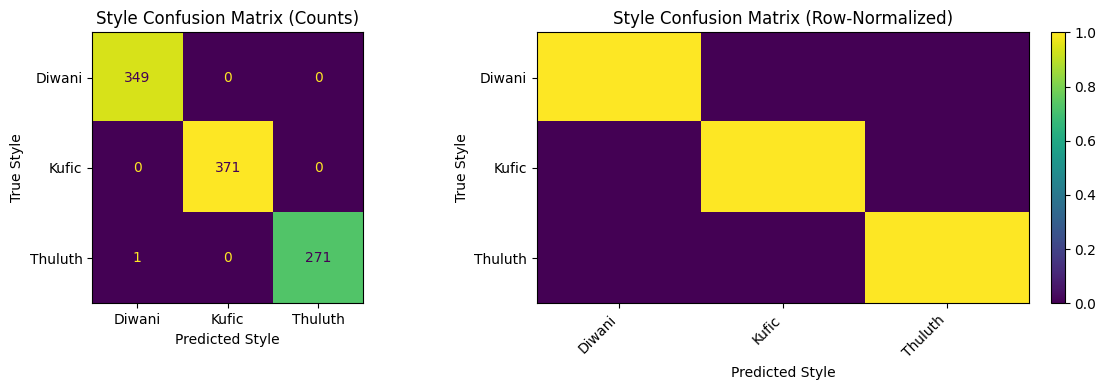

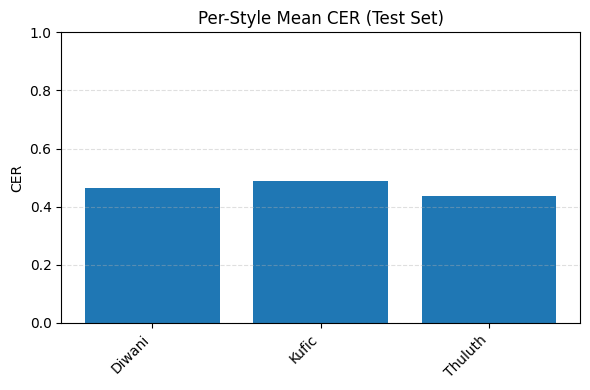

Per-style mean CER:
  Diwani     -> 0.4659
  Kufic      -> 0.4884
  Thuluth    -> 0.4358


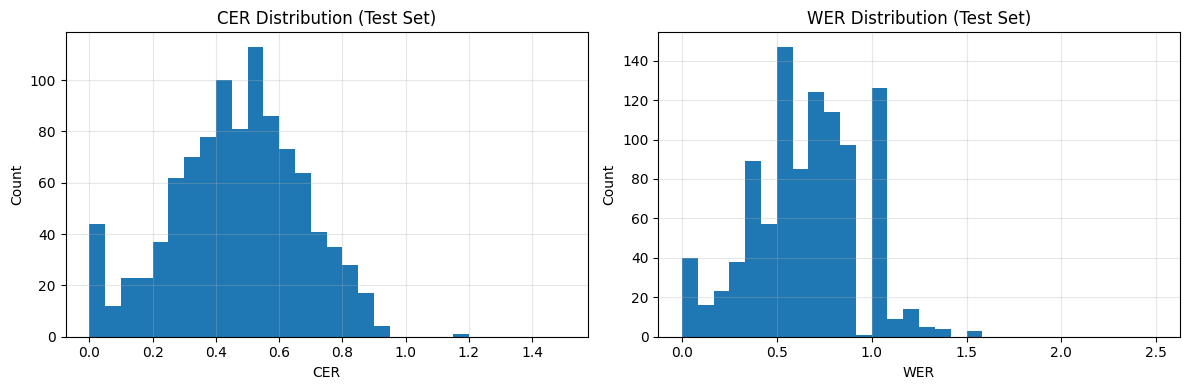

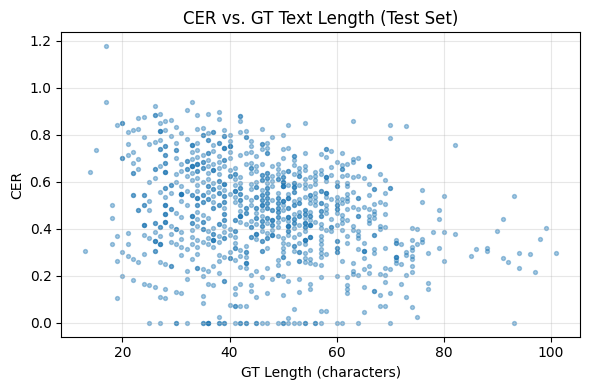


Summary (Test Set Distributions):
  CER  -> mean=0.4661, median=0.4769
  WER  -> mean=0.6375, median=0.6667
  Len  -> mean=46.55, median=46.00
✅ Visual analysis complete.


In [10]:
# %% VISUAL ANALYSIS: CONFUSION MATRIX & ERROR DISTRIBUTIONS (TrOCR-SMALL)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("DETAILED VISUAL ANALYSIS (TEST SET) - TrOCR-SMALL")
print("="*60)

@torch.no_grad()
def collect_test_stats_trocr(model, loader):
    model.eval()
    all_style_true = []
    all_style_pred = []
    cer_list = []
    wer_list = []
    len_list = []
    examples = []  # store a few examples for possible later visualization

    for imgs, labels, label_lens, label_strs, style_idxs in loader:
        # Move to device
        imgs = imgs.to(DEVICE, memory_format=torch.channels_last)
        style_idxs = style_idxs.to(DEVICE)

        # Generate text predictions
        generated = model.generate(imgs, max_len=MAX_SEQ_LEN)
        preds = [decode_trocr(gen.tolist()) for gen in generated]

        # Style prediction from encoder CLS token
        encoder_output = model.encode(imgs)
        cls_token = encoder_output[:, 0]
        style_logits = model.style_head(cls_token)
        style_hat = style_logits.argmax(dim=1)

        for i in range(len(label_strs)):
            gt = label_strs[i]
            pr = preds[i]

            c = cer(gt, pr)
            w = wer(gt, pr)

            cer_list.append(c)
            wer_list.append(w)
            len_list.append(len(gt))

            s_true = int(style_idxs[i].item())
            s_pred = int(style_hat[i].item())
            all_style_true.append(s_true)
            all_style_pred.append(s_pred)

            # keep up to 50 example tuples
            if len(examples) < 50:
                # de-normalize image back to [0,1] grayscale for possible plotting
                im = imgs[i].detach().cpu().numpy().transpose(1, 2, 0)
                im = im * np.array(STD) + np.array(MEAN)
                im = np.clip(im, 0, 1)
                im = im[:, :, 0]

                examples.append({
                    "img": im,
                    "gt": gt,
                    "pred": pr,
                    "style_true": idx2style[s_true],
                    "style_pred": idx2style[s_pred],
                    "cer": c,
                    "wer": w,
                })

    stats = {
        "style_true": np.array(all_style_true, dtype=int),
        "style_pred": np.array(all_style_pred, dtype=int),
        "cer": np.array(cer_list, dtype=float),
        "wer": np.array(wer_list, dtype=float),
        "lengths": np.array(len_list, dtype=int),
        "examples": examples,
    }
    return stats

stats = collect_test_stats_trocr(model, test_loader)

# ---------- STYLE CONFUSION MATRIX ----------
cm = confusion_matrix(stats["style_true"], stats["style_pred"],
                      labels=list(range(len(style_names))))

fig_cm, ax_cm = plt.subplots(1, 2, figsize=(12, 4))

# Raw counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=style_names)
disp.plot(ax=ax_cm[0], colorbar=False)
ax_cm[0].set_title("Style Confusion Matrix (Counts)")
ax_cm[0].set_xlabel("Predicted Style")
ax_cm[0].set_ylabel("True Style")

# Normalized per row (true style)
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True).clip(min=1)
im = ax_cm[1].imshow(cm_norm, aspect='auto')
ax_cm[1].set_xticks(range(len(style_names)))
ax_cm[1].set_yticks(range(len(style_names)))
ax_cm[1].set_xticklabels(style_names, rotation=45, ha='right')
ax_cm[1].set_yticklabels(style_names)
ax_cm[1].set_title("Style Confusion Matrix (Row-Normalized)")
ax_cm[1].set_xlabel("Predicted Style")
ax_cm[1].set_ylabel("True Style")
fig_cm.colorbar(im, ax=ax_cm[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# ---------- PER-STYLE MEAN CER ----------
style_cer = {s: [] for s in style_names}
for s_idx, c in zip(stats["style_true"], stats["cer"]):
    style_cer[idx2style[int(s_idx)]].append(c)

style_mean_cer = {s: (np.mean(v) if len(v) > 0 else np.nan)
                  for s, v in style_cer.items()}

fig_style, ax_style = plt.subplots(figsize=(6, 4))
ax_style.bar(list(style_mean_cer.keys()), list(style_mean_cer.values()))
ax_style.set_title("Per-Style Mean CER (Test Set)")
ax_style.set_ylabel("CER")
ax_style.set_ylim(0, 1.0)
for tick in ax_style.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')
ax_style.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print("Per-style mean CER:")
for s, v in style_mean_cer.items():
    print(f"  {s:10s} -> {v:.4f}")

# ---------- CER / WER HISTOGRAMS ----------
fig_hist, axes_hist = plt.subplots(1, 2, figsize=(12, 4))

axes_hist[0].hist(stats["cer"], bins=30, range=(0, 1.5))
axes_hist[0].set_title("CER Distribution (Test Set)")
axes_hist[0].set_xlabel("CER")
axes_hist[0].set_ylabel("Count")
axes_hist[0].grid(alpha=0.3)

axes_hist[1].hist(stats["wer"], bins=30, range=(0, 2.5))
axes_hist[1].set_title("WER Distribution (Test Set)")
axes_hist[1].set_xlabel("WER")
axes_hist[1].set_ylabel("Count")
axes_hist[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---------- CER vs WORD LENGTH ----------
fig_len, ax_len = plt.subplots(figsize=(6, 4))
ax_len.scatter(stats["lengths"], stats["cer"], s=8, alpha=0.4)
ax_len.set_title("CER vs. GT Text Length (Test Set)")
ax_len.set_xlabel("GT Length (characters)")
ax_len.set_ylabel("CER")
ax_len.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSummary (Test Set Distributions):")
print(f"  CER  -> mean={stats['cer'].mean():.4f}, median={np.median(stats['cer']):.4f}")
print(f"  WER  -> mean={stats['wer'].mean():.4f}, median={np.median(stats['wer']):.4f}")
print(f"  Len  -> mean={stats['lengths'].mean():.2f}, median={np.median(stats['lengths']):.2f}")
print("✅ Visual analysis complete.")


## Character recognition samples (since training code raised an error)

Loading EMA checkpoint: checkpoints_trocr/trocr_best_ema.pt


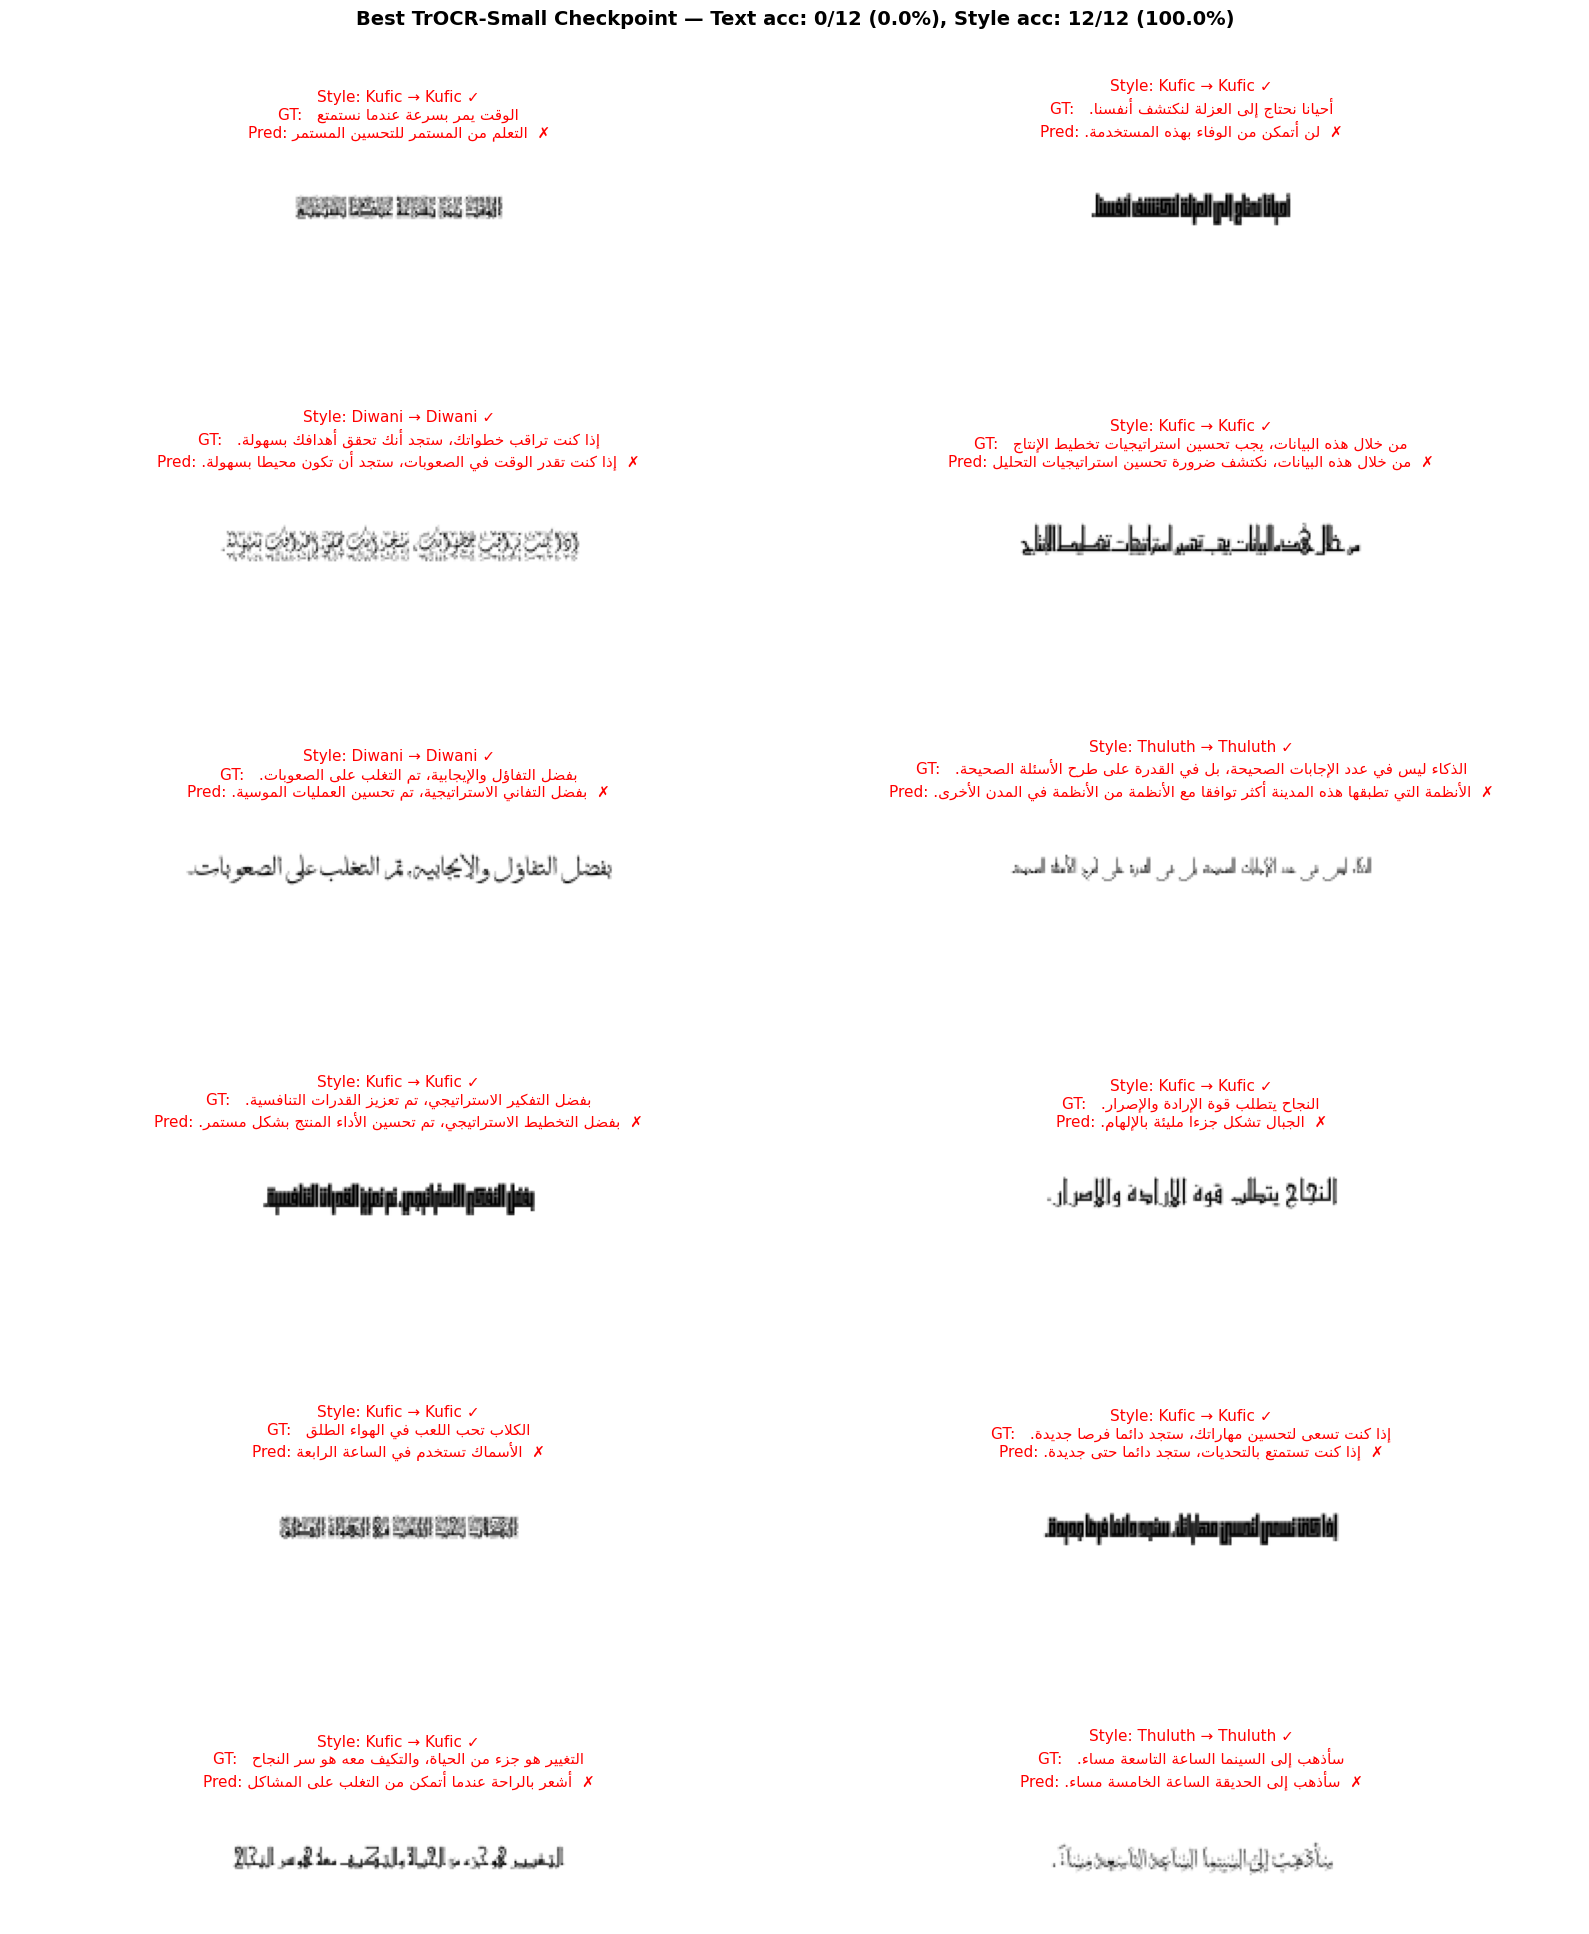

✓ Saved visualization to checkpoints_trocr/trocr_best_sample_predictions.png


In [11]:
# %% QUICK VISUAL CHECK FROM BEST CHECKPOINT (TrOCR-SMALL)
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

ckpt_ema_path = SAVE_DIR / "trocr_best_ema.pt"
ckpt_raw_path = SAVE_DIR / "trocr_best.pt"

if ckpt_ema_path.exists():
    ckpt_path = ckpt_ema_path
    print(f"Loading EMA checkpoint: {ckpt_path}")
else:
    ckpt_path = ckpt_raw_path
    print(f"EMA checkpoint not found, loading RAW best: {ckpt_path}")

ckpt = torch.load(ckpt_path, map_location=DEVICE)

# Rebuild model with same hyperparameters used in training
best_model = TrOCRSmall(
    vocab_size=len(charset),
    num_styles=len(style_names),
    d_model=384,
    nhead=6,
    num_decoder_layers=6,
    dim_feedforward=1536,
    dropout=0.1,
    max_seq_len=MAX_SEQ_LEN,
    img_size=(H_TARGET, W_TARGET)
).to(DEVICE)
best_model = best_model.to(memory_format=torch.channels_last)
best_model.load_state_dict(ckpt["model"], strict=False)
best_model.eval()

plt.rcParams["font.family"] = "DejaVu Sans"

@torch.no_grad()
def show_best_samples(model, loader, k=12):
    model.eval()
    imgs, labels, label_lens, label_strs, style_idxs = next(iter(loader))
    imgs = imgs.to(DEVICE, memory_format=torch.channels_last)
    style_idxs = style_idxs.to(DEVICE)

    # Text predictions
    generated = model.generate(imgs, max_len=MAX_SEQ_LEN)
    preds = [decode_trocr(gen.tolist()) for gen in generated]

    # Style predictions
    encoder_output = model.encode(imgs)
    cls_token = encoder_output[:, 0]
    style_logits = model.style_head(cls_token)
    style_pred = style_logits.softmax(1).argmax(1).cpu().tolist()

    n_samples = min(k, imgs.size(0))
    n_cols = 2
    n_rows = (n_samples + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
    axes = axes.flatten() if n_samples > 1 else [axes]

    correct_text = 0
    correct_style = 0

    for i in range(n_samples):
        im = imgs[i].detach().cpu().numpy().transpose(1, 2, 0)
        im = im * np.array(STD) + np.array(MEAN)
        im = np.clip(im, 0, 1)
        im = im[:, :, 0]

        gt_style = idx2style[style_idxs[i].item()]
        pr_style = idx2style[style_pred[i]]
        gt_text = label_strs[i]
        pr_text = preds[i]

        gt_display = format_arabic_for_display(gt_text)
        pr_display = format_arabic_for_display(pr_text)

        text_ok = (gt_text == pr_text)
        style_ok = (gt_style == pr_style)
        if text_ok:
            correct_text += 1
        if style_ok:
            correct_style += 1

        text_mark = "✓" if text_ok else "✗"
        style_mark = "✓" if style_ok else "✗"
        title_color = "black" if text_ok else "red"

        axes[i].imshow(im, cmap="gray")
        axes[i].axis("off")

        title = (
            f"Style: {gt_style} → {pr_style} {style_mark}\n"
            f"GT:   {gt_display}\n"
            f"Pred: {pr_display}  {text_mark}"
        )
        axes[i].set_title(
            title,
            fontsize=11,
            color=title_color,
            fontfamily="DejaVu Sans",
        )

    for i in range(n_samples, len(axes)):
        axes[i].axis("off")

    total = n_samples
    fig.suptitle(
        f"Best TrOCR-Small Checkpoint — "
        f"Text acc: {correct_text}/{total} ({100*correct_text/total:.1f}%), "
        f"Style acc: {correct_style}/{total} ({100*correct_style/total:.1f}%)",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    out_path = SAVE_DIR / "trocr_best_sample_predictions.png"
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"✓ Saved visualization to {out_path}")

# Run on test set (you can swap test_loader -> val_loader if you prefer)
show_best_samples(best_model, test_loader, k=12)
